# Nx versus T and OA

In [67]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from IPython import get_ipython

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing, ds2df_echam
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

In [148]:

import numpy as np

label_dic =dict(
    T_C=r'T  [$^\circ$C]',
    OA =r'OA [$\mu g m^{-3}$]',
)

In [71]:
select_station = 'SMR'

In [72]:
plot_path = Path(f'Plots/{select_station}')

In [73]:
def make_fn_scat(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_all_years_echam_noresm_{case}_{_x}_{_y}-{select_station}_ukesm.png'
    return plot_path /f

In [74]:
plot_path.mkdir(exist_ok=True, parents=True)

In [75]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'

In [76]:
fn_obs_comb_data_full_time =postproc_data_obs /'SMEAR_data_comb_hourly.csv'

In [77]:
plot_path = Path(f'Plots/{select_station}')

In [78]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalOA_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

## Read in model data. 

In [79]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
            }
di_mod2cases = mod2cases.copy()

In [80]:
from bs_fdbck.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
import numpy as np

In [83]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

### Constants:

In [84]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [85]:
import pandas as pd

## Read in model data

In [86]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv


## Read in observations

In [87]:
df_obs = pd.read_csv(fn_obs_comb_data_full_time,index_col=0)

In [88]:
df_obs = df_obs.rename({'Org':'OA', 'HYY_META.T168':'T_C'}, axis=1)

In [89]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = df_obs
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [90]:
mod2cases['Observations']= ['Observations']

In [91]:
dic_mod_ca = dic_df_pre.copy()

### Fit funcs

In [92]:
from bs_fdbck.util.BSOA_datamanip.fits import *
from bs_fdbck.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [93]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

### Some definitions:

In [94]:
models = ['EC-Earth','ECHAM-SALSA','NorESM']

In [95]:
dic_mod2case={

}

### Save result in dictionary

In [96]:
dic_df_mod_case = di_mod2cases
for mo in models:
    cs = mod2cases[mo]
    for c in cs: 
        if len(cs)>1:
            use_name = f'{mo}_{c}'
        else:
            use_name =mo

In [97]:
dic_df_mod_case = dic_mod_ca.copy()

In [98]:
from bs_fdbck.util.BSOA_datamanip import calculate_daily_median_summer,calculate_summer_median, ds2df_ukesm

NorESM
15456


<AxesSubplot:xlabel='time'>

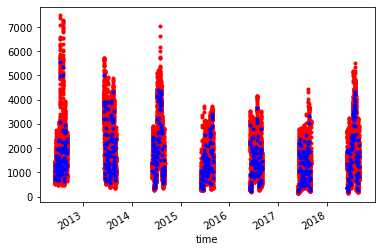

In [99]:

season = 'JJA'
mo ='NorESM'
df_s1 =  dic_df_mod_case['NorESM'][mod2cases['NorESM'][0]]#['N50'].plot()
print(mo)
mask_months = select_months(df_s1, season=season)
df_s1 = df_s1[mask_months].copy()
print(len(df_s1.dropna()))
df_s1['N50'].plot(marker='.', linewidth=0, c='r')
df_s1.resample('D').median()['N50'].plot(marker='.', linewidth=0, c='b')

EC-Earth
4905


<AxesSubplot:xlabel='time'>

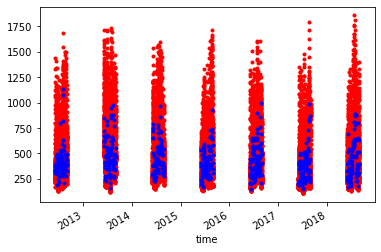

In [100]:

season = 'JJA'
mo ='EC-Earth'
df_s1 =  dic_df_mod_case['EC-Earth'][mod2cases['EC-Earth'][0]]#['N50'].plot()
print(mo)
mask_months = select_months(df_s1, season=season)
df_s1 = df_s1[mask_months].copy()
print(len(df_s1.dropna()))
df_s1['N50'].plot(marker='.', linewidth=0, c='r')
df_s1.resample('D').median()['N50'].plot(marker='.', linewidth=0, c='b')

In [101]:
df_s1.to_xarray()

<xarray.Dataset>
Dimensions:    (time: 15456)
Coordinates:
  * time       (time) datetime64[ns] 2012-06-01 ... 2018-08-31T23:00:00
Data variables: (12/83)
    station    (time) object 'SMR' 'SMR' 'SMR' 'SMR' ... 'SMR' 'SMR' 'SMR' 'SMR'
    time_orig  (time) object '2012-05-31 22:30:00.000000000' ... '2018-08-31 ...
    lev        (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    CCN0.20    (time) float64 67.36 68.15 73.55 85.04 ... 227.9 223.9 219.4
    CCN1.00    (time) float64 95.74 97.16 106.5 128.9 ... 299.7 295.4 290.5
    M_BCACS    (time) float64 3.01e-11 3.069e-11 ... 1.148e-10 1.122e-10
    ...         ...
    SOA2       (time) float64 0.2488 0.2423 0.2422 0.2473 ... 1.39 1.36 1.324
    T_C        (time) float64 nan nan 3.929 nan nan ... nan 16.6 nan nan 14.89
    is_JJA     (time) bool False False True True True ... True True True True
    is_JA      (time) bool False False False False False ... True True True True
    isSummer   (time) bool False False False False False ... True True True True
    month      (time) int64 6 6 6 6 6 6 6 6 6 6 6 6 ... 8 8 8 8 8 8 8 8 8 8 8 8

# Merge with observations:

In [102]:
dic_df_pre = dict()#dic_df_mod_case.copy()#deep=True)
for mod in dic_df_mod_case.keys():
    dic_df_pre[mod] = dic_df_mod_case[mod].copy()

In [103]:
vars_obs = ['OA', 'N100','N50','N200','T_C']

In [104]:
df_obs = df_obs[vars_obs]

In [105]:
df_obs['some_obs_missing'] = df_obs[vars_obs].isnull().any(axis=1)

/tmp/ipykernel_32658/3053598488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['some_obs_missing'] = df_obs[vars_obs].isnull().any(axis=1)


In [106]:
df_for_merge = df_obs[['OA','N100', 'some_obs_missing']].rename({'OA':'obs_OA','N100':'obs_N100',},axis=1)

In [107]:
for mod in dic_df_mod_case.keys():
    print(mod)
    for ca in dic_df_mod_case[mod].keys():
        dic_df_mod_case[mod][ca] = pd.merge(dic_df_pre[mod][ca], df_for_merge ,right_on='time', left_on='time', how='outer')
        dic_df_mod_case[mod][ca]['year'] = dic_df_mod_case[mod][ca].index.year

ECHAM-SALSA
NorESM
EC-Earth
Observations


In [108]:
df_obs_rename = df_obs.rename({'Org':'OA','temperature':'T_C'}, axis=1)

In [109]:
df_obs_rename

,OA,N100,N50,N200,T_C,some_obs_missing
time,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,-6.453500,True
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,-6.553825,True
2012-01-01 02:00:00,NaN,220.985613,458.738202,77.000010,-6.176323,True
2012-01-01 03:00:00,NaN,247.701268,500.153112,86.242482,-5.923486,True
2012-01-01 04:00:00,NaN,313.361915,617.001485,104.131172,-5.757813,True
...,...,...,...,...,...,...
2020-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,True
2020-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,True
2020-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,True


## Add observations to dictionary

In [110]:
dic_df_mod_case['Observations'] = dict()
dic_df_mod_case['Observations']['Observations'] = df_obs_rename

In [111]:
dic_df_mod_case['Observations'].keys()

dict_keys(['Observations'])

In [112]:
dic_mod2case = mod2cases

In [113]:
def add_log(df, varl=None):
    if varl is None:
        varl = ['OA','N100', 'Org','N100 (cm^-3)','N50','N150','N200']
    var_exist = df.columns
    
    varl_f = set(varl).intersection(var_exist)
    print(varl_f)
    for v in varl_f:
        df[f'log10({v})'] = np.log10(df[v])
    return df


for mod in dic_df_mod_case.keys():
    for c in dic_df_mod_case[mod].keys():
    
        dic_df_mod_case[mod][c] = add_log(dic_df_mod_case[mod][c])
        #dic_dfsm_mod_case[mod][c] = add_log(dic_dfsm_mod_case[mod][c])
        
df_obs = add_log(df_obs_rename)

{'OA', 'N200', 'N50', 'N100'}
{'N50', 'N150', 'OA', 'N100', 'N200'}
{'N50', 'N150', 'OA', 'N100', 'N200'}
{'OA', 'N200', 'N50', 'N100'}
{'OA', 'N200', 'N50', 'N100'}


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [114]:
mod='NorESM'

In [115]:
ca = mod2cases[mod][0]

In [116]:
mask_obs_N = dic_df_mod_case[mod][ca]['obs_N100'].notnull()
mask_obs_OA = dic_df_mod_case[mod][ca]['obs_OA'].notnull()

## Compute daily medians:

In [117]:
dic_df_med = dict()
for mo in dic_df_mod_case.keys():
    for ca in dic_df_mod_case[mo].keys():
        if len(dic_df_mod_case[mo].keys())>1:
            use_name = f'{mo}_{ca}'
        else:
            use_name = mo
            
        _df = dic_df_mod_case[mo][ca]
        
        _df = _df[_df['some_obs_missing']==False]
        dic_df_med[use_name] = _df.resample('D').median()

In [118]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model
import seaborn as sns
from matplotlib import pyplot as plt, gridspec as gridspec
from bs_fdbck.util.plot.BSOA_plots import make_cool_grid2, make_cool_grid3
import scipy

### Fit funcs

In [119]:
from bs_fdbck.util.BSOA_datamanip.fits import *
from bs_fdbck.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [120]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

In [121]:
from bs_fdbck.util.BSOA_datamanip.fits import *

In [122]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model, make_cool_grid5

In [123]:
models

['EC-Earth', 'ECHAM-SALSA', 'NorESM']

In [124]:
models_and_obs =  models + ['Observations'] 
models_and_obs

['EC-Earth', 'ECHAM-SALSA', 'NorESM', 'Observations']

## Make plot

In [125]:
def make_plot(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.2,
             source_list = models_and_obs, fig=None, ax=None, daxs=None, axs_extra=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
             ):
    if fig is None: 
        fig, ax, daxs, axs_extra = make_cool_grid3(ncols_extra=2, nrows_extra=3,)# w_ratio_sideplot=.5)

    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()


        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt*.7, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                   )
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax_ex,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                    
                   )
        ax_ex.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo in models_and_obs:

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        sns.histplot(#x=v_x,
                    x= df_s[v_x], 
            edgecolor=cdic_model[mo],
            #log_scale=(xscale=='log'),
            color=cdic_model[mo], 
            element="step",
            label=mo,
            linewidth=1,
            #log_scale=(xscale=='log',False,),

            alpha=.1,
            bins=xbins,
            ax = daxs['x'],
                    
                   )
        print(daxs['x'].get_ylim())
        _fi, ax_test = plt.subplots();
        ax_test = sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = ax_test,
            #ax = daxs['y'],
            linewidth=2,
            
            #edgecolor=None,
            #log_scale=(False,yscale=='log'),
            alpha=.1,
            bins=ybins,
        );
        
        sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = daxs['y'],
            linewidth=1,
            
            #edgecolor=None,
            #log_scale=(xscale=='log',yscale=='log'),
            #log_scale=(False,yscale=='log'),
            
            alpha=.1,
            bins=ybins,
            )
        xlim_dist_n = list(ax_test.get_xlim())
        _fi.clf()
        #if xlim_dist_n[1]>xlim_dist_n[1]:
        xlim_dist[1] = max(xlim_dist_n[1],xlim_dist[1])
        #daxs['y'].set_xlim([0,xlim_dist[1]])
        
        #plt.show()

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)


    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)

    return

#### WET_mid

## T to OA, exp

### JA

In [126]:
models_and_obs

['EC-Earth', 'ECHAM-SALSA', 'NorESM', 'Observations']

<AxesSubplot:xlabel='time'>

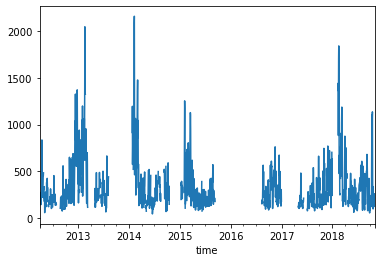

In [149]:
df_s =  dic_df_med['EC-Earth']
df_s['N100'].plot()

(0.0, 66.15)
(0.0, 66.15)
(0.0, 66.15)
(0.0, 66.15)
EC-Earth
EC-Earth
Beta: [0.19271399 0.13955375]
Beta Std Error: [0.02577172 0.00686835]
Beta Covariance: [[ 9.31073973e-04 -2.44410726e-04]
 [-2.44410726e-04  6.61305695e-05]]
Residual Variance: 0.7133500063483653
Inverse Condition #: 0.003766827926841228
Reason(s) for Halting:
  Sum of squares convergence
[0.19271399 0.13955375]
reason for haltng
ECHAM-SALSA
ECHAM-SALSA
Beta: [0.08555686 0.14175576]
Beta Std Error: [0.01587712 0.00868755]
Beta Covariance: [[ 0.00058041 -0.00031382]
 [-0.00031382  0.00017377]]
Residual Variance: 0.43432200461943965
Inverse Condition #: 0.0067384541401787346
Reason(s) for Halting:
  Sum of squares convergence
[0.08555686 0.14175576]
reason for haltng
NorESM
NorESM
Beta: [0.15491497 0.14354858]
Beta Std Error: [0.02214586 0.00675401]
Beta Covariance: [[ 5.17165634e-04 -1.54904988e-04]
 [-1.54904988e-04  4.81024557e-05]]
Residual Variance: 0.9483213151687246
Inverse Condition #: 0.004688962786380017
Reas

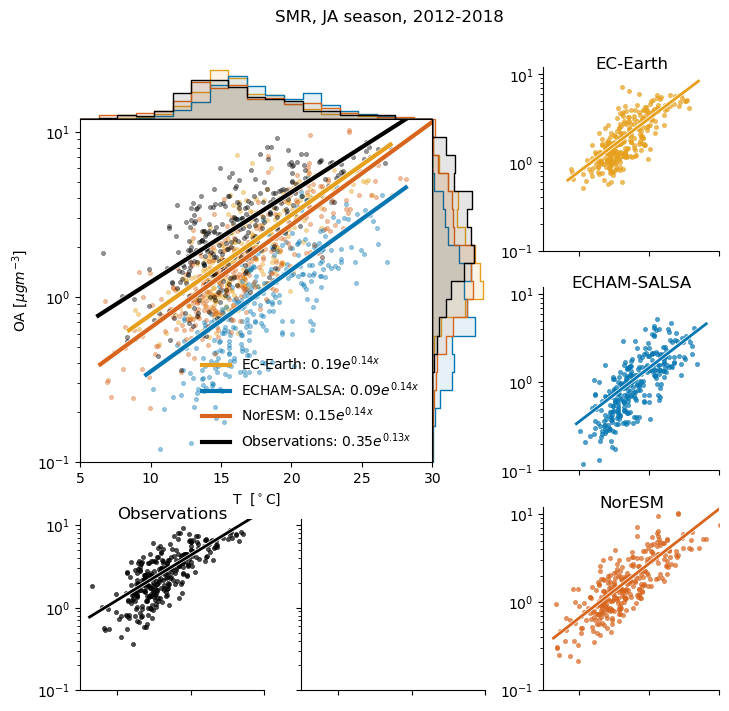

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [128]:
fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,12]


season='JA'
v_x = 'T_C'
v_y = 'OA'


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')


    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



plt.show()

# Nx new version

In [129]:
def make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.4,
             source_list = models_and_obs, fig=None, 
               axs=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
             ):
    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax in zip(source_list, axs[:]):
        
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                    
                   )
        ax.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo,ax in zip(source_list, axs):

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        ax.set_ylim(ylims)
        ax.set_xlim(xlims)

        sns.despine(ax = ax)

    return

#### WET_mid

In [130]:
def plot_fit(func, popt, mo, xlims, yscale, xscale, ax):
    x = np.linspace(*xlims)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))
    
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{label}')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))

    #ax.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
    #
    #)

    #ax.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
    #          )    
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)



In [131]:
models_and_obs[::-1]

['Observations', 'NorESM', 'ECHAM-SALSA', 'EC-Earth']

Observations
NorESM
ECHAM-SALSA
EC-Earth
Observations
NorESM
ECHAM-SALSA
EC-Earth


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

Observations
Beta: [ 56.14457219 -32.53102847]
Beta Std Error: [1.04981006 3.67463438]
Beta Covariance: [[ 3.11436191 -9.30793083]
 [-9.30793083 38.15714613]]
Residual Variance: 0.3538770379773544
Inverse Condition #: 0.13195228784998997
Reason(s) for Halting:
  Sum of squares convergence
[ 56.14457219 -32.53102847]
reason for haltng
NorESM
Beta: [ 35.41540503 -11.71524041]
Beta Std Error: [0.89586541 2.20334068]
Beta Covariance: [[ 1.91828378 -3.78999206]
 [-3.78999206 11.60354321]]
Residual Variance: 0.4183817012314126
Inverse Condition #: 0.20888727592519546
Reason(s) for Halting:
  Sum of squares convergence
[ 35.41540503 -11.71524041]
reason for haltng
ECHAM-SALSA
Beta: [38.28977706 -4.34025897]
Beta Std Error: [0.96612643 1.42374924]
Beta Covariance: [[ 6.75099261 -8.15496808]
 [-8.15496808 14.66110549]]
Residual Variance: 0.13826119113859553
Inverse Condition #: 0.2938126493144871
Reason(s) for Halting:
  Sum of squares convergence
[38.28977706 -4.34025897]
reason for haltng
EC-

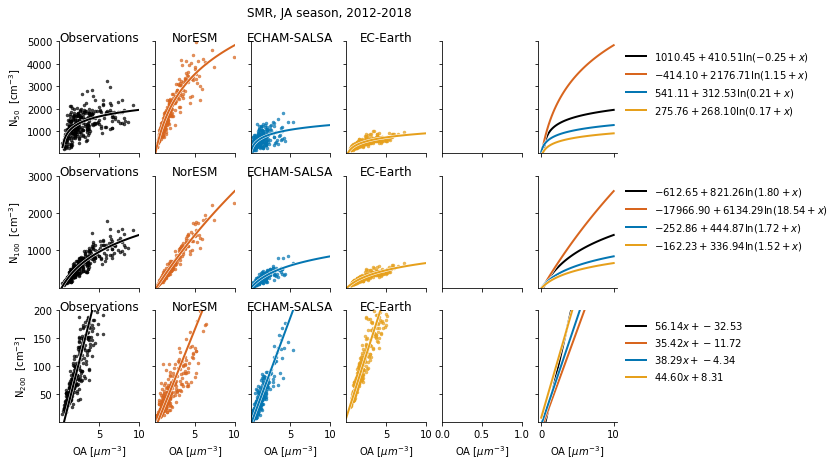

In [132]:
## Settings
alpha_scatt = 0.5
figsize=[10,7]

xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
source_list = models_and_obs[::-1]

xlims = [.01,10]

ylims = [1,5000]

# OBS: 
v_y = 'N50'
v_x = 'OA'
ylab = r'N$_{50}$  [cm$^{-3}$]'



xscale='linear'
yscale='linear'

fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')


## Settings
alpha_scatt = 0.6

legs =[]

# Make plot
axs_sub = axs_all[0,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )


for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)


xlims = [.01,10]

ylims = [1,3000]

# OBS: 
v_y = 'N100'
ylab = r'N$_{100}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[1,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list =source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )
for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

#leg = axs_sub[-1].legend(bbox_to_anchor=(1.1,1,), frameon=False)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)

    
    
xlims = [.01,10]

ylims = [1,200]





# OBS: 
v_y = 'N200'
ylab = r'N$_{200}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[2,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )

for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)
legs.append(leg)

    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 



    
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
#ax.legend(frameon=False)
fig.savefig(fn, dpi=150, bbox_inches='tight')#)
fig.savefig(fn.with_suffix('.pdf'), dpi=150, bbox_inches='tight')#)
print(fn)

Observations
Beta: [299.84247333 559.665198  ]
Beta Std Error: [18.06465103 55.44292902]
Beta Covariance: [[  96.72473144 -244.16137891]
 [-244.16137891  911.10978659]]
Residual Variance: 3.373817759105318
Inverse Condition #: 0.16401963558022387
Reason(s) for Halting:
  Iteration limit reached
[299.84247333 559.665198  ]
reason for haltng
Going for least square
NorESM
Beta: [683.79725651 498.30559551]
Beta Std Error: [19.48641305 47.56656634]
Beta Covariance: [[  745.98485489 -1473.85815112]
 [-1473.85815112  4444.97996136]]
Residual Variance: 0.5090187702622999
Inverse Condition #: 0.2065793917653954
Reason(s) for Halting:
  Sum of squares convergence
[683.79725651 498.30559551]
reason for haltng
ECHAM-SALSA
Beta: [355.31021769 221.92576118]
Beta Std Error: [20.13405875 27.0233376 ]
Beta Covariance: [[ 585.61687457 -612.69265099]
 [-612.69265099 1054.94275338]]
Residual Variance: 0.6922278698011991
Inverse Condition #: 0.3357932016559991
Reason(s) for Halting:
  Iteration limit reach

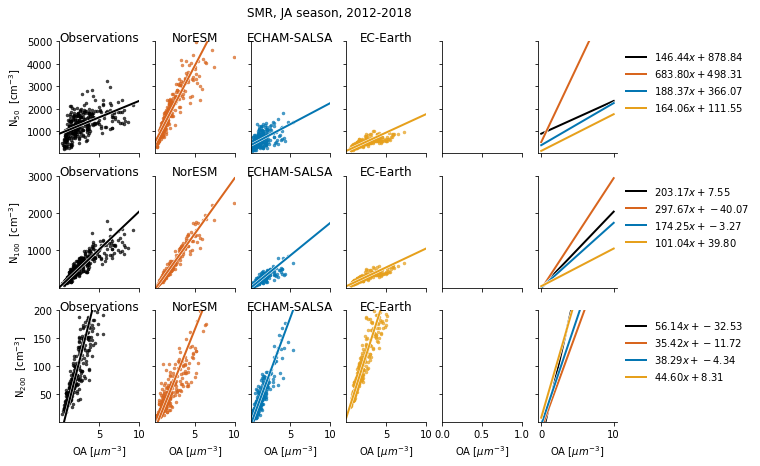

In [133]:
## Settings
alpha_scatt = 0.5
figsize=[10,7]

xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
source_list = models_and_obs[::-1]

xlims = [.01,10]

ylims = [1,5000]

# OBS: 
v_y = 'N50'
v_x = 'OA'
ylab = r'N$_{50}$  [cm$^{-3}$]'



xscale='linear'
yscale='linear'

fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')


## Settings
alpha_scatt = 0.6

legs =[]

# Make plot
axs_sub = axs_all[0,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )


for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)


xlims = [.01,10]

ylims = [1,3000]

# OBS: 
v_y = 'N100'
ylab = r'N$_{100}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[1,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list =source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )
for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

#leg = axs_sub[-1].legend(bbox_to_anchor=(1.1,1,), frameon=False)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

legs.append(leg)

    
    
xlims = [.01,10]

ylims = [1,200]





# OBS: 
v_y = 'N200'
ylab = r'N$_{200}$  [cm$^{-3}$]'


xscale='linear'
yscale='linear'
axs_sub = axs_all[2,:]
axs_sub[0].set_ylabel(ylab)

make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=.4,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
         )

for mo, ax in zip(source_list, axs_sub):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    plot_fit(func, popt, mo, xlims, yscale, xscale, ax)
    plot_fit(func, popt, mo, xlims, yscale, xscale, axs_sub[-1])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)
legs.append(leg)

    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 



    
fn = make_fn_scat(f'together_linear_{season}', v_x, 'Nx')
#ax.legend(frameon=False)
fig.savefig(fn, dpi=150, bbox_inches='tight')#)
fig.savefig(fn.with_suffix('.pdf'), dpi=150, bbox_inches='tight')#)
print(fn)

[Plots/SMR/scat_all_years_echam_noresm_together_JA_OA_Nx-SMR_ukesm.png](Plots/SMR/scat_all_years_echam_noresm_together_JA_OA_Nx-SMR_ukesm.png)

## N50

(0.0, 87.15)
(0.0, 106.05)
(0.0, 106.05)
(0.0, 106.05)
EC-Earth
ECHAM-SALSA
NorESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

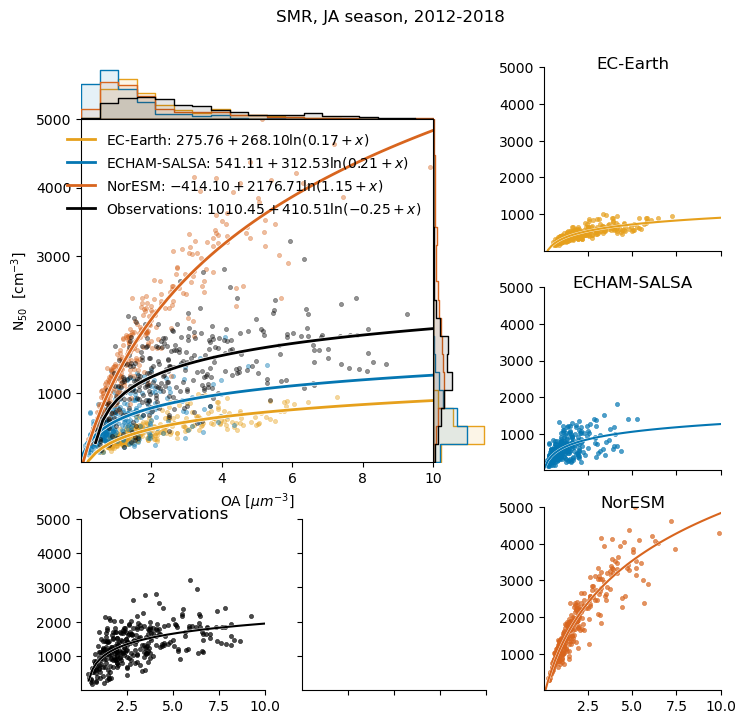

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [135]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{50}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,5000]

# OBS: 
v_x = 'OA'
v_y = 'N50'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    x = np.linspace(*xlims)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))
    
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )

    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

EC-Earth
ECHAM-SALSA
NorESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/SMR/scat_all_years_echam_noresm_residual_ln_JA_OA_N50-SMR_ukesm.png


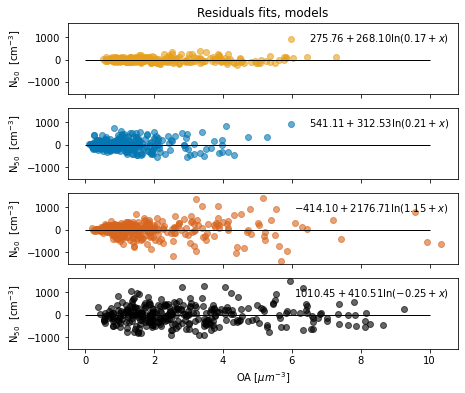

In [136]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{50}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

#ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N50'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_ln_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## N100

(0.0, 87.15)
(0.0, 106.05)
(0.0, 106.05)
(0.0, 106.05)
EC-Earth
ECHAM-SALSA
NorESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


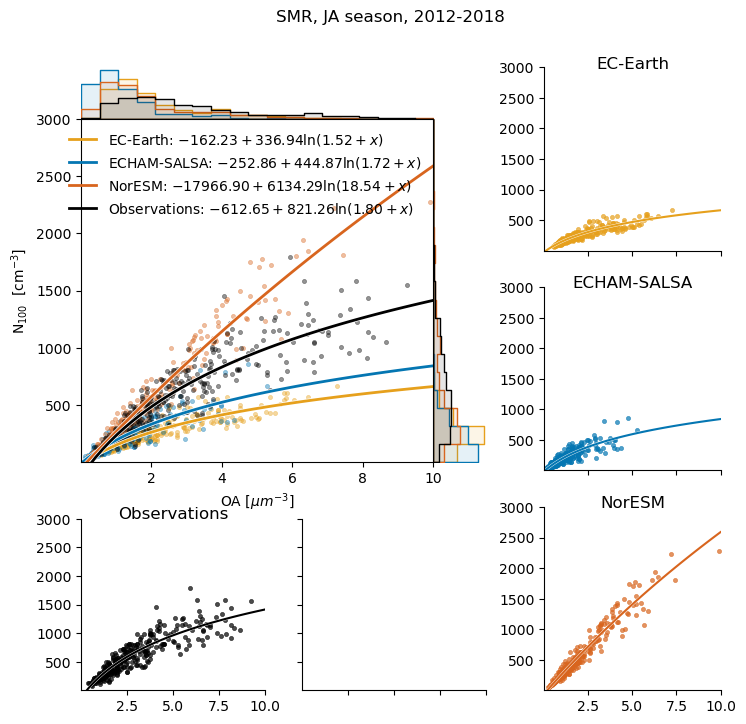

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [137]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{100}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,3000]

# OBS: 
v_x = 'OA'
v_y = 'N100'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    x = np.linspace(*xlims)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))
    
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')
    #     label='fit: %5.3f exp( %5.3f x) +  %5.3f' % tuple(popt))

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )

    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

EC-Earth
ECHAM-SALSA
NorESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:462: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/SMR/scat_all_years_echam_noresm_residual_ln_JA_OA_N100-SMR_ukesm.png


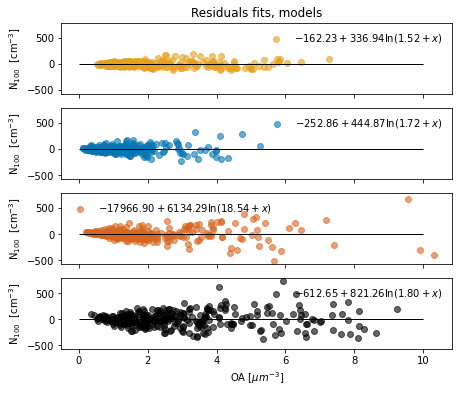

In [138]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{100}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

#ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N100'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_ln_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## N200

(0.0, 87.15)
(0.0, 106.05)
(0.0, 106.05)
(0.0, 106.05)
EC-Earth
Beta: [44.5971425   8.30644234]
Beta Std Error: [0.85006143 2.0823102 ]
Beta Covariance: [[ 4.11770995 -8.65315424]
 [-8.65315424 24.708477  ]]
Residual Variance: 0.17548696976430256
Inverse Condition #: 0.17527034901087626
Reason(s) for Halting:
  Sum of squares convergence
[44.5971425   8.30644234]
reason for haltng
ECHAM-SALSA
Beta: [38.28977706 -4.34025897]
Beta Std Error: [0.96612643 1.42374924]
Beta Covariance: [[ 6.75099261 -8.15496808]
 [-8.15496808 14.66110549]]
Residual Variance: 0.13826119113859553
Inverse Condition #: 0.2938126493144871
Reason(s) for Halting:
  Sum of squares convergence
[38.28977706 -4.34025897]
reason for haltng
NorESM
Beta: [ 35.41540503 -11.71524041]
Beta Std Error: [0.89586541 2.20334068]
Beta Covariance: [[ 1.91828378 -3.78999206]
 [-3.78999206 11.60354321]]
Residual Variance: 0.4183817012314126
Inverse Condition #: 0.20888727592519546
Reason(s) for Halting:
  Sum of squares convergence
[

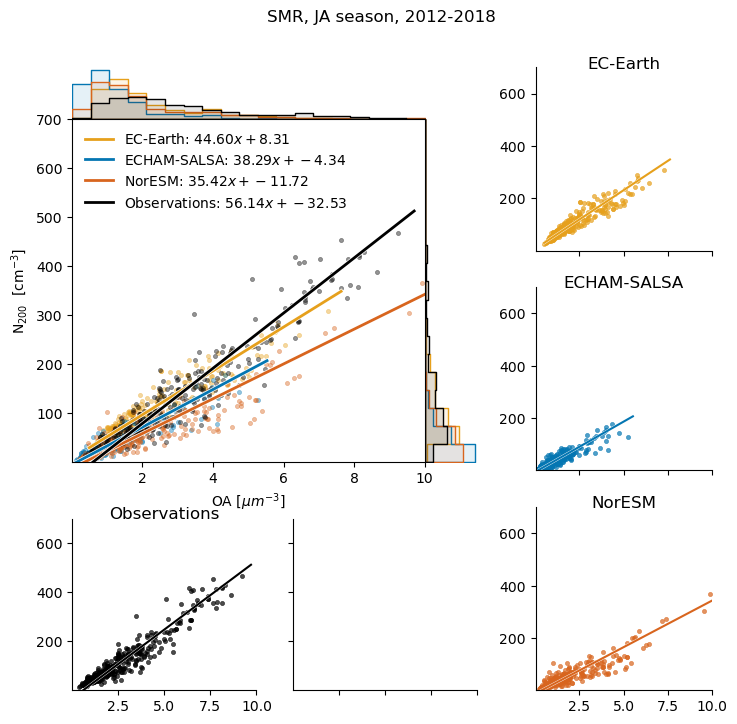

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [139]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim,1000)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

EC-Earth
Beta: [44.5971425   8.30644234]
Beta Std Error: [0.85006143 2.0823102 ]
Beta Covariance: [[ 4.11770995 -8.65315424]
 [-8.65315424 24.708477  ]]
Residual Variance: 0.17548696976430256
Inverse Condition #: 0.17527034901087626
Reason(s) for Halting:
  Sum of squares convergence
[44.5971425   8.30644234]
reason for haltng
ECHAM-SALSA
Beta: [38.28977706 -4.34025897]
Beta Std Error: [0.96612643 1.42374924]
Beta Covariance: [[ 6.75099261 -8.15496808]
 [-8.15496808 14.66110549]]
Residual Variance: 0.13826119113859553
Inverse Condition #: 0.2938126493144871
Reason(s) for Halting:
  Sum of squares convergence
[38.28977706 -4.34025897]
reason for haltng
NorESM
Beta: [ 35.41540503 -11.71524041]
Beta Std Error: [0.89586541 2.20334068]
Beta Covariance: [[ 1.91828378 -3.78999206]
 [-3.78999206 11.60354321]]
Residual Variance: 0.4183817012314126
Inverse Condition #: 0.20888727592519546
Reason(s) for Halting:
  Sum of squares convergence
[ 35.41540503 -11.71524041]
reason for haltng
Observatio

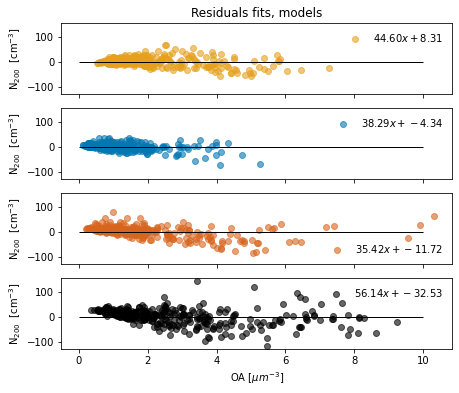

In [140]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_linear_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## N200: ax

(0.0, 87.15)
(0.0, 106.05)
(0.0, 106.05)
(0.0, 106.05)
EC-Earth
Beta: [47.57007958]
Beta Std Error: [0.47609874]
Beta Covariance: [[1.23867266]]
Residual Variance: 0.18299427884235842
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[47.57007958]
reason for haltng
ECHAM-SALSA
Beta: [35.95475321]
Beta Std Error: [0.5283557]
Beta Covariance: [[1.95751093]]
Residual Variance: 0.14260954386108154
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[35.95475321]
reason for haltng
NorESM
Beta: [31.84320984]
Beta Std Error: [0.50809212]
Beta Covariance: [[0.5545746]]
Residual Variance: 0.46550563335615136
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[31.84320984]
reason for haltng
Observations
Beta: [48.69420042]
Beta Std Error: [0.55198593]
Beta Covariance: [[0.64117682]]
Residual Variance: 0.4752019353293328
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[48.69420042]
reason fo

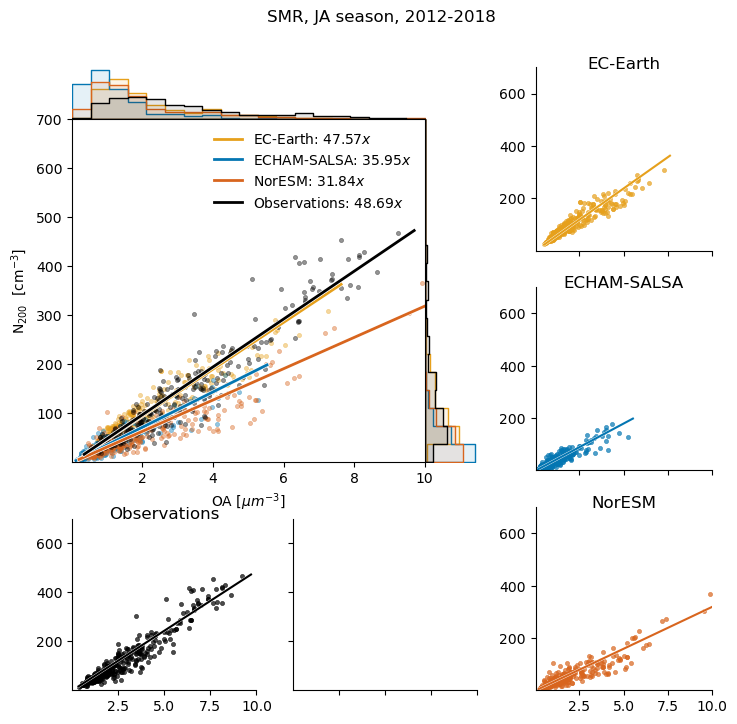

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [141]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6



# Make plot
make_plot(v_x, v_y, xlims, ylims, season, 
          xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale=yscale,
          xscale=xscale,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='ax', return_func=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim,1000)
    ax.plot(x, func(x, *popt), c='w', linewidth=3,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=2, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=2,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
              )    
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


ax.set_yscale(yscale)
ax.set_xscale(xscale)


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

### Residuals

EC-Earth
Beta: [47.57007958]
Beta Std Error: [0.47609874]
Beta Covariance: [[1.23867266]]
Residual Variance: 0.18299427884235842
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[47.57007958]
reason for haltng
ECHAM-SALSA
Beta: [35.95475321]
Beta Std Error: [0.5283557]
Beta Covariance: [[1.95751093]]
Residual Variance: 0.14260954386108154
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[35.95475321]
reason for haltng
NorESM
Beta: [31.84320984]
Beta Std Error: [0.50809212]
Beta Covariance: [[0.5545746]]
Residual Variance: 0.46550563335615136
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[31.84320984]
reason for haltng
Observations
Beta: [48.69420042]
Beta Std Error: [0.55198593]
Beta Covariance: [[0.64117682]]
Residual Variance: 0.4752019353293328
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
[48.69420042]
reason for haltng
Plots/SMR/scat_all_years_echam_noresm_residual

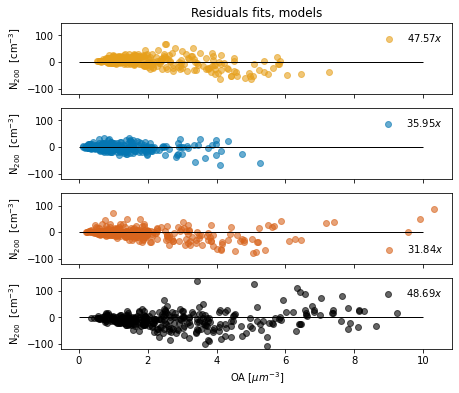

In [142]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='ax', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_ax_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

EC-Earth
Beta: [44.5971425   8.30644234]
Beta Std Error: [0.85006143 2.0823102 ]
Beta Covariance: [[ 4.11770995 -8.65315424]
 [-8.65315424 24.708477  ]]
Residual Variance: 0.17548696976430256
Inverse Condition #: 0.17527034901087626
Reason(s) for Halting:
  Sum of squares convergence
[44.5971425   8.30644234]
reason for haltng
ECHAM-SALSA
Beta: [38.28977706 -4.34025897]
Beta Std Error: [0.96612643 1.42374924]
Beta Covariance: [[ 6.75099261 -8.15496808]
 [-8.15496808 14.66110549]]
Residual Variance: 0.13826119113859553
Inverse Condition #: 0.2938126493144871
Reason(s) for Halting:
  Sum of squares convergence
[38.28977706 -4.34025897]
reason for haltng
NorESM
Beta: [ 35.41540503 -11.71524041]
Beta Std Error: [0.89586541 2.20334068]
Beta Covariance: [[ 1.91828378 -3.78999206]
 [-3.78999206 11.60354321]]
Residual Variance: 0.4183817012314126
Inverse Condition #: 0.20888727592519546
Reason(s) for Halting:
  Sum of squares convergence
[ 35.41540503 -11.71524041]
reason for haltng
Observatio

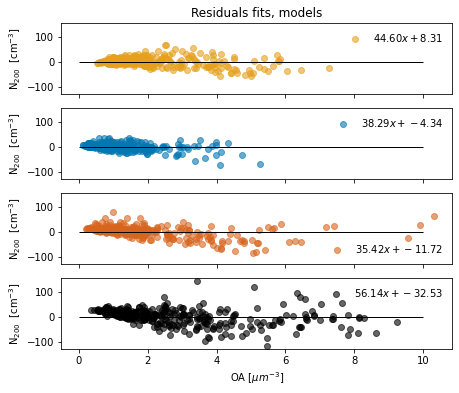

In [143]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_linear_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

EC-Earth
Beta: [44.5971425   8.30644234]
Beta Std Error: [0.85006143 2.0823102 ]
Beta Covariance: [[ 4.11770995 -8.65315424]
 [-8.65315424 24.708477  ]]
Residual Variance: 0.17548696976430256
Inverse Condition #: 0.17527034901087626
Reason(s) for Halting:
  Sum of squares convergence
[44.5971425   8.30644234]
reason for haltng
ECHAM-SALSA
Beta: [38.28977706 -4.34025897]
Beta Std Error: [0.96612643 1.42374924]
Beta Covariance: [[ 6.75099261 -8.15496808]
 [-8.15496808 14.66110549]]
Residual Variance: 0.13826119113859553
Inverse Condition #: 0.2938126493144871
Reason(s) for Halting:
  Sum of squares convergence
[38.28977706 -4.34025897]
reason for haltng
NorESM
Beta: [ 35.41540503 -11.71524041]
Beta Std Error: [0.89586541 2.20334068]
Beta Covariance: [[ 1.91828378 -3.78999206]
 [-3.78999206 11.60354321]]
Residual Variance: 0.4183817012314126
Inverse Condition #: 0.20888727592519546
Reason(s) for Halting:
  Sum of squares convergence
[ 35.41540503 -11.71524041]
reason for haltng
Observatio

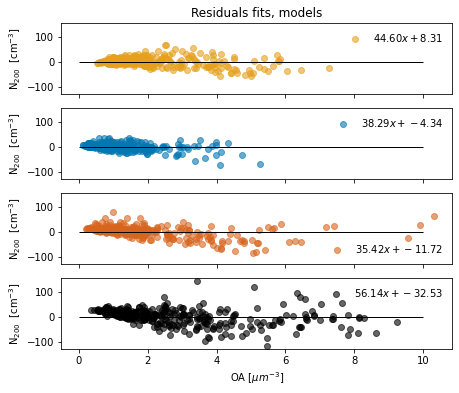

In [144]:

## Settings
alpha_scatt = 0.5

figsize=[7,6]
ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'residual_linear_{season}', v_x, v_y)
ax.legend(frameon=False)
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

EC-Earth
Beta: [44.5971425   8.30644234]
Beta Std Error: [0.85006143 2.0823102 ]
Beta Covariance: [[ 4.11770995 -8.65315424]
 [-8.65315424 24.708477  ]]
Residual Variance: 0.17548696976430256
Inverse Condition #: 0.17527034901087626
Reason(s) for Halting:
  Sum of squares convergence
[44.5971425   8.30644234]
reason for haltng
ECHAM-SALSA
Beta: [38.28977706 -4.34025897]
Beta Std Error: [0.96612643 1.42374924]
Beta Covariance: [[ 6.75099261 -8.15496808]
 [-8.15496808 14.66110549]]
Residual Variance: 0.13826119113859553
Inverse Condition #: 0.2938126493144871
Reason(s) for Halting:
  Sum of squares convergence
[38.28977706 -4.34025897]
reason for haltng
NorESM
Beta: [ 35.41540503 -11.71524041]
Beta Std Error: [0.89586541 2.20334068]
Beta Covariance: [[ 1.91828378 -3.78999206]
 [-3.78999206 11.60354321]]
Residual Variance: 0.4183817012314126
Inverse Condition #: 0.20888727592519546
Reason(s) for Halting:
  Sum of squares convergence
[ 35.41540503 -11.71524041]
reason for haltng
Observatio

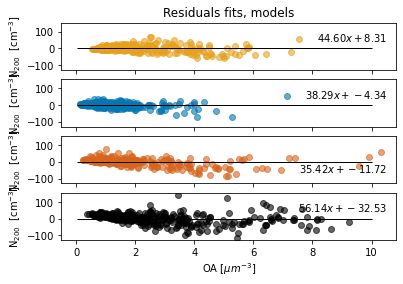

In [145]:

## Settings
alpha_scatt = 0.5

ylab = r'N$_{200}$  [cm$^{-3}$]'
xlab = r'OA [$\mu m^{-3}$]'

season = 'JA'
xlims = [.01,10]

ylims = [1,700]

# OBS: 
v_x = 'OA'
v_y = 'N200'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True)

## Settings
alpha_scatt = 0.6





for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
axs[0].set_title(r'Residuals fits, models')


    
fn = make_fn_scat(f'lin1_{season}', v_x, v_y)
ax.legend(frameon=False)
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

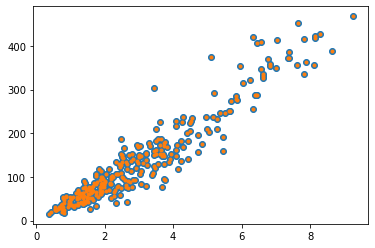

In [146]:
plt.scatter(df_s[v_x].dropna(),out.y)
plt.scatter(df_s[v_x].dropna(),df_s[v_y].dropna(), marker='.')

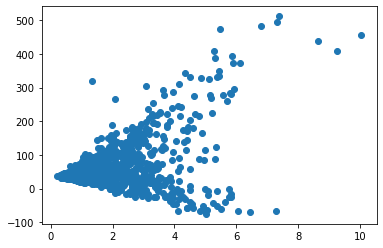

In [150]:
#plt.scatter(df_s[v_x].dropna(),out.y)

#plt.scatter(df_s[v_x].dropna(),func(df_s[v_x].dropna(),*popt))
#plt.scatter(df_s[v_x],df_s[v_y])
plt.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x].dropna(),*popt))
#plt.scatter(df_s[v_x].dropna(),df_s[v_y].dropna(), marker='.')